# **Proyecto #8: Clustering y visualización de curvas de luz de estrellas periódicas**
## **EL4106 - Inteligencia Computacional - Primavera 2022**
### **Parte 2 : Reducción de dimensiones**
##### **Profesor:** Pablo Estevez
##### **Auxiliar:** Juan Uturria 
##### **Ayudante:** Rafael de la Sotta Vargas
##### **Estudiantes:** Macarena Ríos - Melanie Peña


## 1) Librerías a importar para la experiencia

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from google.colab import drive
from google.colab import files
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-tuner --upgrade

In [ ]:
pip install tensorflow

In [ ]:
#para el autoencoder
import math
import tensorflow as tf
import keras_tuner.tuners as kt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## 2) Unión de la data de características de todas las clases

In [3]:
#se cargan todas las dataframes de los features obtenidos y asignamos las clases correspondientes
CEP = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/CEP_features.csv")
CEP["classALeRCE"] = "CEP"
DSCT = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/DSCT_features.csv")
DSCT["classALeRCE"] = "DSCT"
E = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/E_features.csv")
E["classALeRCE"] = "E"
LPV = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/LPV_features.csv")
LPV["classALeRCE"] = "LPV"
POther = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/POther_features.csv")
POther["classALeRCE"] = "Periodic-Other"
RRL = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/RRL_features.csv")
RRL["classALeRCE"] = "RRL"

In [ ]:
#continuamos uniendo toda la data en solo una data frame
first = pd.concat([CEP,DSCT],ignore_index=True)
second = pd.concat([first,E],ignore_index=True)
third = pd.concat([second,LPV],ignore_index=True)
fourth = pd.concat([third,POther],ignore_index=True)
final = pd.concat([fourth,RRL],ignore_index=True)


Para facilitar el proceso, se decide guardar este dataframe para utilizar a futuro.

In [ ]:
#Código de ejemplo para poder descargar la data en un csv, descomentar si es necesario
#final.to_csv('features_totales.csv', index=False) 
#files.download('features_totales.csv')

##3) Situación inicial

In [4]:
#se carga la  data para no tener que correr la concatenación cada vez
final = pd.read_csv('/content/drive/MyDrive/Proyecto8/Features/features_totales.csv')
final

,oid,MHPS_ratio_r,MHPS_low_r,MHPS_high_r,MHPS_non_zero_r,MHPS_PN_flag_r,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,MHPS_non_zero_g,...,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g,classALeRCE
0,ZTF17aabulac,1.155378,0.499402,0.432241,218.0,0.0,0.316374,0.179732,0.568099,324.0,...,-1.577956,0.524465,0.726911,1.0,0.001149,0.675791,-0.035507,8.204546e-01,0.000135,CEP
1,ZTF18aaxjixb,1.132515,0.365305,0.322561,98.0,0.0,0.789070,0.457251,0.579481,164.0,...,-1.462347,0.373529,0.628436,1.0,0.000683,0.510957,0.011341,7.331026e-01,-0.000085,CEP
2,ZTF18aauqjtk,3.794028,0.295547,0.077898,86.0,0.0,2.733041,0.428944,0.156947,165.0,...,-1.318882,0.407151,0.698594,1.0,0.000729,0.550771,-0.031368,9.271285e-01,-0.000126,CEP
3,ZTF18aaaaajq,0.847033,0.173251,0.204538,83.0,0.0,1.470625,0.755096,0.513452,72.0,...,-1.126781,0.376544,0.918371,1.0,0.000481,0.501414,-0.016520,3.724786e-13,0.000036,CEP
4,ZTF17aaadqhs,8.914537,2.292220,0.257133,9.0,0.0,2.679551,3.124052,1.165886,30.0,...,0.071383,0.483527,0.930662,1.0,0.000624,0.629238,-0.033390,8.618697e-02,0.000302,CEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,ZTF18abrymro,NaN,NaN,NaN,NaN,NaN,500.229095,1.112249,0.002223,6.0,...,-0.558214,0.276899,0.922015,1.0,0.000246,0.619373,0.253660,9.699323e-01,-0.007780,RRL
3613,ZTF19aacipqq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.545906,0.208093,0.933660,1.0,0.000129,0.360810,0.050974,1.304112e-03,-0.000099,RRL
3614,ZTF19abudhbr,NaN,NaN,NaN,NaN,NaN,32.730782,0.012715,0.000388,5.0,...,2.488790,0.213859,0.690182,1.0,0.000118,0.701657,0.627883,9.899342e-01,0.002072,RRL
3615,ZTF19aarsxkm,2.631819,0.067844,0.025778,4.0,0.0,95.264198,1.635817,0.017171,5.0,...,-1.676820,0.488585,0.957055,1.0,0.000845,15.000000,1.393247,7.731402e-01,0.000390,RRL


Revisando la data se puede verificar que hay una gran cantidad de características que no poseen valores númericos, es decir, son nulas para cierta cantidad de estrellas. Se procede a calcular cuantos valores nulos poseen cada una de las columnas/características.

In [ ]:
#bloque para ver el nombre de las características que tenemos
keys = final.keys()
ft = keys.to_numpy()
ft

array(['oid', 'MHPS_ratio_r', 'MHPS_low_r', 'MHPS_high_r',
       'MHPS_non_zero_r', 'MHPS_PN_flag_r', 'MHPS_ratio_g', 'MHPS_low_g',
       'MHPS_high_g', 'MHPS_non_zero_g', 'MHPS_PN_flag_g',
       'Multiband_period', 'PPE', 'Period_band_r', 'delta_period_r',
       'Period_band_g', 'delta_period_g', 'GP_DRW_sigma_r',
       'GP_DRW_tau_r', 'GP_DRW_sigma_g', 'GP_DRW_tau_g', 'Psi_CS_r',
       'Psi_eta_r', 'Psi_CS_g', 'Psi_eta_g', 'Harmonics_mag_1_r',
       'Harmonics_mag_2_r', 'Harmonics_mag_3_r', 'Harmonics_mag_4_r',
       'Harmonics_mag_5_r', 'Harmonics_mag_6_r', 'Harmonics_mag_7_r',
       'Harmonics_phase_2_r', 'Harmonics_phase_3_r',
       'Harmonics_phase_4_r', 'Harmonics_phase_5_r',
       'Harmonics_phase_6_r', 'Harmonics_phase_7_r', 'Harmonics_mse_r',
       'Harmonics_mag_1_g', 'Harmonics_mag_2_g', 'Harmonics_mag_3_g',
       'Harmonics_mag_4_g', 'Harmonics_mag_5_g', 'Harmonics_mag_6_g',
       'Harmonics_mag_7_g', 'Harmonics_phase_2_g', 'Harmonics_phase_3_g',
       'Harm

In [ ]:
#bloque para poder verificar cuantos valores nulos posee cada columna/característica
novalue = final.isna().sum()
aux = novalue.to_numpy()
aux

array([   0,  725,  725,  725,  725,  725,  331,  331,  331,  331,  331,
          1,    1,  462,  462,  167,  167,  312,  312,   61,   61,  354,
        354,   99,   99,  313,  313,  313,  313,  313,  313,  313,  313,
        313,  313,  313,  313,  313,  313,   62,   62,   62,   62,   62,
         62,   62,   62,   62,   62,   62,   62,   62,   62,  312,   61,
          1,    1,    1,    1,    1,    1,  462,  462,  462,  462,  462,
       2166,  462,  769,  462,  462,  462,  462,  462,  462,  462,  462,
        462,  462,  462,  462,  462,  462,  462,  462,  462,  462,  167,
        167,  167,  167,  167, 2000,  167,  426,  167,  167,  167,  167,
        167,  167,  167,  167,  167,  167,  167,  167,  167,  167,  167,
        167,  167,  167,    0])

In [ ]:
#bloque para asignar a cada columna cuantos valores nulos posee en total
def assign(a,b):
  aux_list =[]
  for i in range(len(a)):
    x = [a[i],b[i]]
    aux_list.append(x)
  return aux_list

assign(ft,aux)

[['oid', 0],
 ['MHPS_ratio_r', 725],
 ['MHPS_low_r', 725],
 ['MHPS_high_r', 725],
 ['MHPS_non_zero_r', 725],
 ['MHPS_PN_flag_r', 725],
 ['MHPS_ratio_g', 331],
 ['MHPS_low_g', 331],
 ['MHPS_high_g', 331],
 ['MHPS_non_zero_g', 331],
 ['MHPS_PN_flag_g', 331],
 ['Multiband_period', 1],
 ['PPE', 1],
 ['Period_band_r', 462],
 ['delta_period_r', 462],
 ['Period_band_g', 167],
 ['delta_period_g', 167],
 ['GP_DRW_sigma_r', 312],
 ['GP_DRW_tau_r', 312],
 ['GP_DRW_sigma_g', 61],
 ['GP_DRW_tau_g', 61],
 ['Psi_CS_r', 354],
 ['Psi_eta_r', 354],
 ['Psi_CS_g', 99],
 ['Psi_eta_g', 99],
 ['Harmonics_mag_1_r', 313],
 ['Harmonics_mag_2_r', 313],
 ['Harmonics_mag_3_r', 313],
 ['Harmonics_mag_4_r', 313],
 ['Harmonics_mag_5_r', 313],
 ['Harmonics_mag_6_r', 313],
 ['Harmonics_mag_7_r', 313],
 ['Harmonics_phase_2_r', 313],
 ['Harmonics_phase_3_r', 313],
 ['Harmonics_phase_4_r', 313],
 ['Harmonics_phase_5_r', 313],
 ['Harmonics_phase_6_r', 313],
 ['Harmonics_phase_7_r', 313],
 ['Harmonics_mse_r', 313],
 ['Harmo

Es inmediato notar que las características 'Eta_e_r' y 'Eta_e_g' poseen valores elevados de valores nulos, es decir, una gran cantidad de el sample de las estrellas no poseen esta características en estas bandas.

##Nos quedamos con las características más importantes segun el paper

In [5]:
def finalfeatures(df):
  features = ["Multiband_period","GP_DRW_tau_g","IAR_phi_g","Amplitude_g","ExcessVar_g","Meanvariance_g","Std_g","GP_DRW_sigma_g","GP_DRW_tau_r","PercentAmplitude_g","SF_ML_amplitude_g","Gskew_g","Q31_g","Autocor_length_g","IAR_phi_r","SF_ML_gamma_g","Amplitude_r","classALeRCE"]
  a = final.columns
  for j in range(len(a)):
    if a[j] not in features:
      df.drop(a[j],axis=1,inplace=True)
  return df

In [6]:
finalfeatures(final)

,Multiband_period,GP_DRW_tau_r,GP_DRW_sigma_g,GP_DRW_tau_g,Amplitude_r,IAR_phi_r,Amplitude_g,Autocor_length_g,Gskew_g,Meanvariance_g,PercentAmplitude_g,Q31_g,Std_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,classALeRCE
0,15.780730,4.808991,0.245956,5.251873,0.576968,0.821701,0.748833,2.0,0.571878,0.033938,0.076212,1.005811,0.524465,0.001149,0.675791,-0.035507,8.204546e-01,CEP
1,11.927180,2.248160,0.126136,2.937845,0.362886,0.672017,0.556808,1.0,0.156255,0.026167,0.047838,0.670627,0.373529,0.000683,0.510957,0.011341,7.331026e-01,CEP
2,30.995104,6.378780,0.132610,10.612898,0.452118,0.856191,0.645168,3.0,0.229613,0.027025,0.060667,0.743516,0.407151,0.000729,0.550771,-0.031368,9.271285e-01,CEP
3,1.849328,0.578738,0.140541,0.070337,0.414722,0.187589,0.569841,1.0,-0.504367,0.022026,0.049284,0.686710,0.376544,0.000481,0.501414,-0.016520,3.724786e-13,CEP
4,1.287263,2.205629,0.231433,0.375745,0.611173,0.641274,0.739046,1.0,-1.083969,0.025622,0.068012,0.382981,0.483527,0.000624,0.629238,-0.033390,8.618697e-02,CEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,1.459293,1.000000,0.076936,22.366812,NaN,NaN,0.375277,2.0,-0.373780,0.015877,0.032047,0.527552,0.276899,0.000246,0.619373,0.253660,9.699323e-01,RRL
3613,0.106462,1.000000,0.042368,0.375027,NaN,NaN,0.273005,1.0,-0.475491,0.011544,0.028133,0.233963,0.208093,0.000129,0.360810,0.050974,1.304112e-03,RRL
3614,0.096689,1.000000,0.041240,26.426442,NaN,NaN,0.340149,1.0,0.378703,0.011284,0.028052,0.071594,0.213859,0.000118,0.701657,0.627883,9.899342e-01,RRL
3615,0.097275,36.807612,0.241035,5.299086,0.468070,0.971783,0.629217,1.0,0.000477,0.029123,0.037500,0.921388,0.488585,0.000845,15.000000,1.393247,7.731402e-01,RRL


In [7]:
final

,Multiband_period,GP_DRW_tau_r,GP_DRW_sigma_g,GP_DRW_tau_g,Amplitude_r,IAR_phi_r,Amplitude_g,Autocor_length_g,Gskew_g,Meanvariance_g,PercentAmplitude_g,Q31_g,Std_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,classALeRCE
0,15.780730,4.808991,0.245956,5.251873,0.576968,0.821701,0.748833,2.0,0.571878,0.033938,0.076212,1.005811,0.524465,0.001149,0.675791,-0.035507,8.204546e-01,CEP
1,11.927180,2.248160,0.126136,2.937845,0.362886,0.672017,0.556808,1.0,0.156255,0.026167,0.047838,0.670627,0.373529,0.000683,0.510957,0.011341,7.331026e-01,CEP
2,30.995104,6.378780,0.132610,10.612898,0.452118,0.856191,0.645168,3.0,0.229613,0.027025,0.060667,0.743516,0.407151,0.000729,0.550771,-0.031368,9.271285e-01,CEP
3,1.849328,0.578738,0.140541,0.070337,0.414722,0.187589,0.569841,1.0,-0.504367,0.022026,0.049284,0.686710,0.376544,0.000481,0.501414,-0.016520,3.724786e-13,CEP
4,1.287263,2.205629,0.231433,0.375745,0.611173,0.641274,0.739046,1.0,-1.083969,0.025622,0.068012,0.382981,0.483527,0.000624,0.629238,-0.033390,8.618697e-02,CEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,1.459293,1.000000,0.076936,22.366812,NaN,NaN,0.375277,2.0,-0.373780,0.015877,0.032047,0.527552,0.276899,0.000246,0.619373,0.253660,9.699323e-01,RRL
3613,0.106462,1.000000,0.042368,0.375027,NaN,NaN,0.273005,1.0,-0.475491,0.011544,0.028133,0.233963,0.208093,0.000129,0.360810,0.050974,1.304112e-03,RRL
3614,0.096689,1.000000,0.041240,26.426442,NaN,NaN,0.340149,1.0,0.378703,0.011284,0.028052,0.071594,0.213859,0.000118,0.701657,0.627883,9.899342e-01,RRL
3615,0.097275,36.807612,0.241035,5.299086,0.468070,0.971783,0.629217,1.0,0.000477,0.029123,0.037500,0.921388,0.488585,0.000845,15.000000,1.393247,7.731402e-01,RRL


In [8]:
final.to_csv('features_periodicas.csv', index=False) 
files.download('features_periodicas.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##4) Reemplazo de datos no numéricos

In [9]:
final.fillna(-999,inplace=True)
final

,Multiband_period,GP_DRW_tau_r,GP_DRW_sigma_g,GP_DRW_tau_g,Amplitude_r,IAR_phi_r,Amplitude_g,Autocor_length_g,Gskew_g,Meanvariance_g,PercentAmplitude_g,Q31_g,Std_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,classALeRCE
0,15.780730,4.808991,0.245956,5.251873,0.576968,0.821701,0.748833,2.0,0.571878,0.033938,0.076212,1.005811,0.524465,0.001149,0.675791,-0.035507,8.204546e-01,CEP
1,11.927180,2.248160,0.126136,2.937845,0.362886,0.672017,0.556808,1.0,0.156255,0.026167,0.047838,0.670627,0.373529,0.000683,0.510957,0.011341,7.331026e-01,CEP
2,30.995104,6.378780,0.132610,10.612898,0.452118,0.856191,0.645168,3.0,0.229613,0.027025,0.060667,0.743516,0.407151,0.000729,0.550771,-0.031368,9.271285e-01,CEP
3,1.849328,0.578738,0.140541,0.070337,0.414722,0.187589,0.569841,1.0,-0.504367,0.022026,0.049284,0.686710,0.376544,0.000481,0.501414,-0.016520,3.724786e-13,CEP
4,1.287263,2.205629,0.231433,0.375745,0.611173,0.641274,0.739046,1.0,-1.083969,0.025622,0.068012,0.382981,0.483527,0.000624,0.629238,-0.033390,8.618697e-02,CEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,1.459293,1.000000,0.076936,22.366812,-999.000000,-999.000000,0.375277,2.0,-0.373780,0.015877,0.032047,0.527552,0.276899,0.000246,0.619373,0.253660,9.699323e-01,RRL
3613,0.106462,1.000000,0.042368,0.375027,-999.000000,-999.000000,0.273005,1.0,-0.475491,0.011544,0.028133,0.233963,0.208093,0.000129,0.360810,0.050974,1.304112e-03,RRL
3614,0.096689,1.000000,0.041240,26.426442,-999.000000,-999.000000,0.340149,1.0,0.378703,0.011284,0.028052,0.071594,0.213859,0.000118,0.701657,0.627883,9.899342e-01,RRL
3615,0.097275,36.807612,0.241035,5.299086,0.468070,0.971783,0.629217,1.0,0.000477,0.029123,0.037500,0.921388,0.488585,0.000845,15.000000,1.393247,7.731402e-01,RRL


In [10]:
final

,Multiband_period,GP_DRW_tau_r,GP_DRW_sigma_g,GP_DRW_tau_g,Amplitude_r,IAR_phi_r,Amplitude_g,Autocor_length_g,Gskew_g,Meanvariance_g,PercentAmplitude_g,Q31_g,Std_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,classALeRCE
0,15.780730,4.808991,0.245956,5.251873,0.576968,0.821701,0.748833,2.0,0.571878,0.033938,0.076212,1.005811,0.524465,0.001149,0.675791,-0.035507,8.204546e-01,CEP
1,11.927180,2.248160,0.126136,2.937845,0.362886,0.672017,0.556808,1.0,0.156255,0.026167,0.047838,0.670627,0.373529,0.000683,0.510957,0.011341,7.331026e-01,CEP
2,30.995104,6.378780,0.132610,10.612898,0.452118,0.856191,0.645168,3.0,0.229613,0.027025,0.060667,0.743516,0.407151,0.000729,0.550771,-0.031368,9.271285e-01,CEP
3,1.849328,0.578738,0.140541,0.070337,0.414722,0.187589,0.569841,1.0,-0.504367,0.022026,0.049284,0.686710,0.376544,0.000481,0.501414,-0.016520,3.724786e-13,CEP
4,1.287263,2.205629,0.231433,0.375745,0.611173,0.641274,0.739046,1.0,-1.083969,0.025622,0.068012,0.382981,0.483527,0.000624,0.629238,-0.033390,8.618697e-02,CEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,1.459293,1.000000,0.076936,22.366812,-999.000000,-999.000000,0.375277,2.0,-0.373780,0.015877,0.032047,0.527552,0.276899,0.000246,0.619373,0.253660,9.699323e-01,RRL
3613,0.106462,1.000000,0.042368,0.375027,-999.000000,-999.000000,0.273005,1.0,-0.475491,0.011544,0.028133,0.233963,0.208093,0.000129,0.360810,0.050974,1.304112e-03,RRL
3614,0.096689,1.000000,0.041240,26.426442,-999.000000,-999.000000,0.340149,1.0,0.378703,0.011284,0.028052,0.071594,0.213859,0.000118,0.701657,0.627883,9.899342e-01,RRL
3615,0.097275,36.807612,0.241035,5.299086,0.468070,0.971783,0.629217,1.0,0.000477,0.029123,0.037500,0.921388,0.488585,0.000845,15.000000,1.393247,7.731402e-01,RRL


In [12]:
final.to_csv('features_periodicas_sinnan.csv', index=False) 
files.download('features_periodicas_sinnan.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##5) División de data

In [ ]:
#Separamos la data para realizar oversampling y luego normalización
features = ["Multiband_period","GP_DRW_tau_g","IAR_phi_g","Amplitude_g","ExcessVar_g",
            "Meanvariance_g","Std_g","GP_DRW_sigma_g","GP_DRW_tau_r","PercentAmplitude_g",
            "SF_ML_amplitude_g","Gskew_g","Q31_g", "Autocor_length_g","IAR_phi_r",
            "SF_ML_gamma_g","Amplitude_r"]

X = final.loc[:, features] #se define la data correspondiente las características
Y = final.loc[:, ['classALeRCE']] #se define la data correspondiente a las clases, que corresponde a el target

### Data correspondiente a las características


In [ ]:
x

,Multiband_period,GP_DRW_tau_g,IAR_phi_g,Amplitude_g,ExcessVar_g,Meanvariance_g,Std_g,GP_DRW_sigma_g,GP_DRW_tau_r,PercentAmplitude_g,SF_ML_amplitude_g,Gskew_g,Q31_g,Autocor_length_g,IAR_phi_r,SF_ML_gamma_g,Amplitude_r
0,15.780730,5.251873,8.204546e-01,0.748833,0.001149,0.033938,0.524465,0.245956,4.808991,0.076212,0.675791,0.571878,1.005811,2.0,0.821701,-0.035507,0.576968
1,11.927180,2.937845,7.331026e-01,0.556808,0.000683,0.026167,0.373529,0.126136,2.248160,0.047838,0.510957,0.156255,0.670627,1.0,0.672017,0.011341,0.362886
2,30.995104,10.612898,9.271285e-01,0.645168,0.000729,0.027025,0.407151,0.132610,6.378780,0.060667,0.550771,0.229613,0.743516,3.0,0.856191,-0.031368,0.452118
3,1.849328,0.070337,3.724786e-13,0.569841,0.000481,0.022026,0.376544,0.140541,0.578738,0.049284,0.501414,-0.504367,0.686710,1.0,0.187589,-0.016520,0.414722
4,1.287263,0.375745,8.618697e-02,0.739046,0.000624,0.025622,0.483527,0.231433,2.205629,0.068012,0.629238,-1.083969,0.382981,1.0,0.641274,-0.033390,0.611173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,1.459293,22.366812,9.699323e-01,0.375277,0.000246,0.015877,0.276899,0.076936,1.000000,0.032047,0.619373,-0.373780,0.527552,2.0,-999.000000,0.253660,-999.000000
3613,0.106462,0.375027,1.304112e-03,0.273005,0.000129,0.011544,0.208093,0.042368,1.000000,0.028133,0.360810,-0.475491,0.233963,1.0,-999.000000,0.050974,-999.000000
3614,0.096689,26.426442,9.899342e-01,0.340149,0.000118,0.011284,0.213859,0.041240,1.000000,0.028052,0.701657,0.378703,0.071594,1.0,-999.000000,0.627883,-999.000000
3615,0.097275,5.299086,7.731402e-01,0.629217,0.000845,0.029123,0.488585,0.241035,36.807612,0.037500,15.000000,0.000477,0.921388,1.0,0.971783,1.393247,0.468070


### Data correspondiente a las clases

In [ ]:
y

,classALeRCE
0,CEP
1,CEP
2,CEP
3,CEP
4,CEP
...,...
3612,RRL
3613,RRL
3614,RRL
3615,RRL


##6) Split Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, train_size = .75)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2712, 17)
(2712, 1)
(905, 17)
(905, 1)


##7) Normalización de features QUANTILE_TRANSFORM

In [ ]:
from sklearn.preprocessing import quantile_transform

In [ ]:
X_train_qt = quantile_transform(X_train, n_quantiles=100, random_state=0, copy=True)
X_test_qt = quantile_transform(X_test, n_quantiles=100, random_state=0, copy=True)

In [ ]:
X_train_qt

array([[0.01950561, 0.41146642, 0.36383153, ..., 0.        , 0.07350793,
        0.        ],
       [0.39538419, 0.68015873, 0.69719404, ..., 0.        , 0.09497367,
        0.        ],
       [0.05787624, 0.48333639, 0.46446479, ..., 0.63490939, 0.33926688,
        0.45038451],
       ...,
       [0.05291132, 0.26488437, 0.31495663, ..., 0.37231267, 0.19550269,
        0.71055102],
       [0.9862327 , 0.83781813, 0.83834204, ..., 0.85488795, 0.80405577,
        0.34373918],
       [0.12165344, 0.29449499, 0.1996214 , ..., 0.2645307 , 0.65657744,
        0.58099545]])

In [ ]:
X_test_qt

array([[0.65121816, 0.68252259, 0.69590446, ..., 0.6921894 , 0.21444113,
        0.393826  ],
       [0.36942471, 0.91152303, 0.91922134, ..., 0.70291018, 0.95621309,
        0.1471597 ],
       [0.64098601, 0.82832309, 0.85559721, ..., 0.82379886, 0.7916635 ,
        0.20234266],
       ...,
       [0.03169019, 0.89202374, 0.        , ..., 0.87900863, 0.        ,
        0.68782047],
       [0.7949329 , 0.52380837, 0.5322905 , ..., 0.52410122, 0.45848274,
        0.51870859],
       [0.4036216 , 0.15307257, 0.20099267, ..., 0.42540818, 0.71381874,
        0.72046301]])

In [ ]:
X_train_qtn = quantile_transform(X_train, n_quantiles=100, output_distribution="normal", random_state=0, copy=True)
X_test_qtn = quantile_transform(X_test, n_quantiles=100, output_distribution= "normal", random_state=0, copy=True)

##7.caca) Verificación de resultados preliminares con PCA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


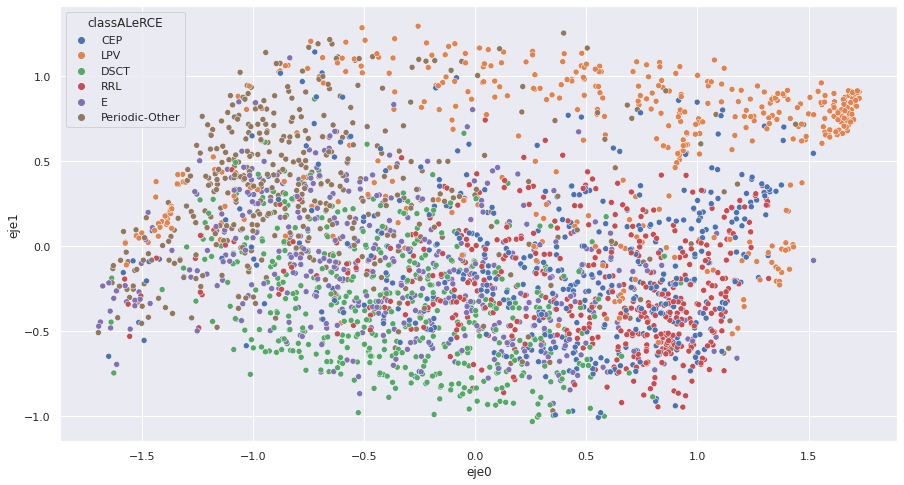

In [ ]:
#PCA
pca = PCA(n_components=2)
pca.fit(X_train_qt)
X_pca = pca.transform(X_train_qt)

P = y_train
P['eje0']=X_pca[:,0]
P['eje1']=X_pca[:,1]

sns.scatterplot('eje0','eje1',data=P, hue='classALeRCE')
sns.set(rc={'figure.figsize':(20,15)})
plt.show()

## 8) Reducción con UMAP

In [ ]:
pip install umap-learn

In [ ]:
import umap

###QUANTIL UNIFORME

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


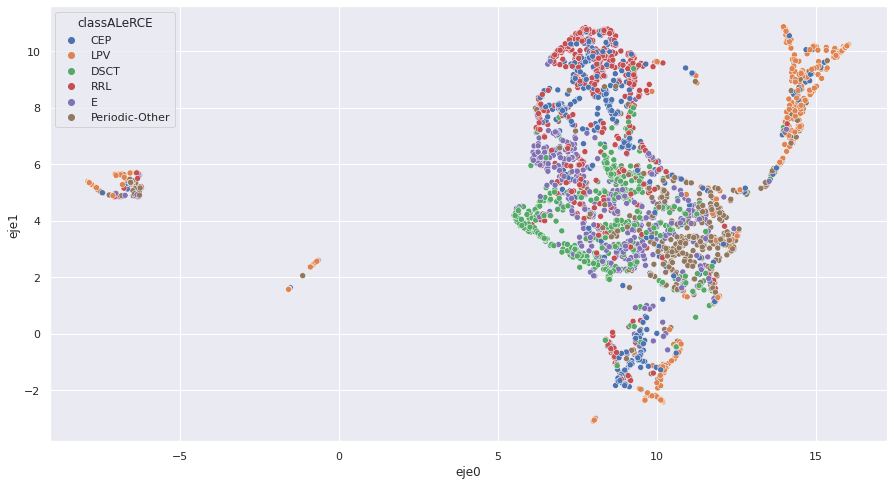

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_train_qt)

U = y_train
U['eje0']=embedding[:, 0]
U['eje1']=embedding[:, 1]

sns.scatterplot('eje0','eje1',data=U, hue='classALeRCE')
sns.set(rc={'figure.figsize':(15,8)})
plt.show()

###QUANTIL NORMAL

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


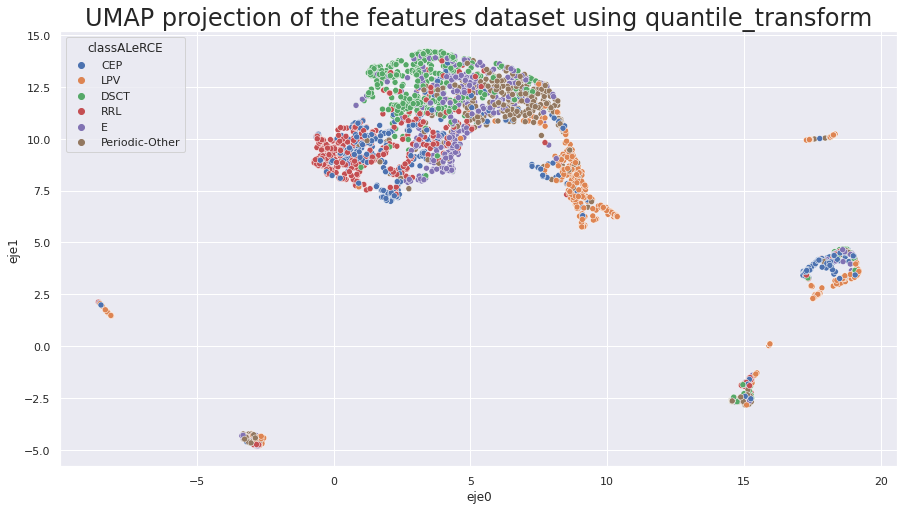

In [ ]:
reducer = umap.UMAP()
embeddingn = reducer.fit_transform(X_train_qtn)

Un = y_train
Un['eje0']=embeddingn[:, 0]
Un['eje1']=embeddingn[:, 1]

sns.scatterplot('eje0','eje1',data=Un, hue='classALeRCE')
sns.set(rc={'figure.figsize':(15,8)})
plt.title('UMAP projection of the features dataset using quantile_transform', fontsize=24);
plt.show()

###MINMAX

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


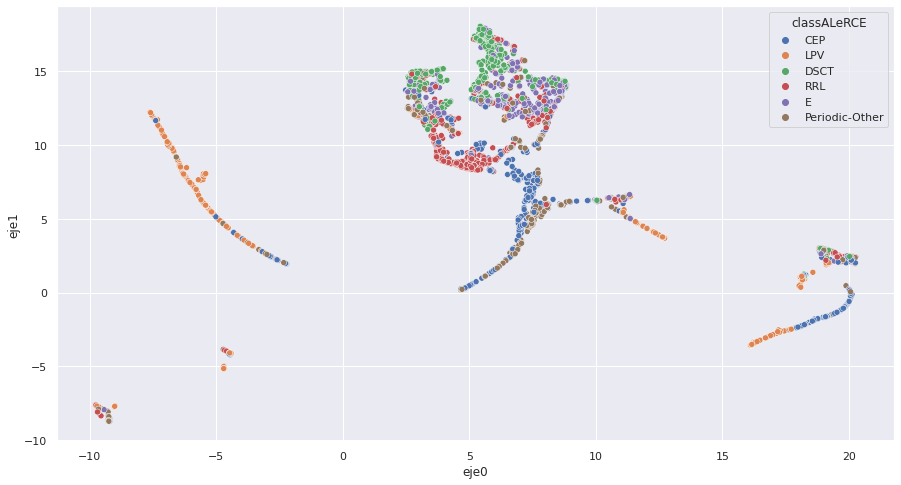

In [ ]:
reducer = umap.UMAP()
X_train_mm = MinMaxScaler().fit_transform(X_train)
embedding_mm = reducer.fit_transform(X_train_mm)

Umm = y_train
Umm['eje0']=embedding_mm[:, 0]
Umm['eje1']=embedding_mm[:, 1]

sns.scatterplot('eje0','eje1',data=Umm, hue='classALeRCE')
sns.set(rc={'figure.figsize':(15,8)})
plt.show()

###STANDARD

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


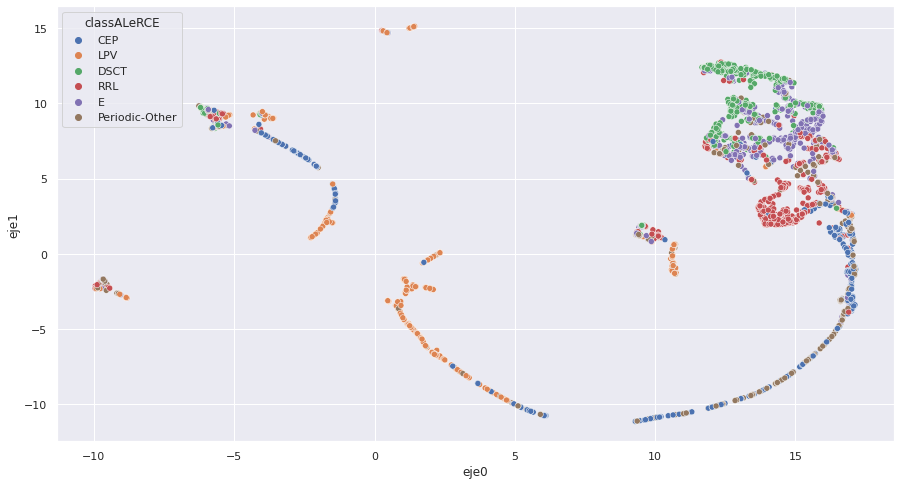

In [ ]:
reducer = umap.UMAP()
X_train_std = StandardScaler().fit_transform(X_train)
embedding_std = reducer.fit_transform(X_train_std)

Ustd = y_train
Ustd['eje0']=embedding_std[:, 0]
Ustd['eje1']=embedding_std[:, 1]

sns.scatterplot('eje0','eje1',data=Ustd, hue='classALeRCE')
sns.set(rc={'figure.figsize':(15,8)})
plt.show()

## 9) Autoencoder (NO FUNCIONAL)


In [ ]:
class AutoEncoders(Model):

  def __init__(self, output_units):

    super().__init__()
    self.encoder = Sequential(
        [
          Dense(32, activation="relu"),
          Dense(16, activation="relu"),
          Dense(7, activation="relu")
        ]
    )

    self.decoder = Sequential(
        [
          Dense(16, activation="relu"),
          Dense(32, activation="relu"),
          Dense(output_units, activation="sigmoid")
        ]
    )

def call(self, inputs):

  encoded = self.encoder(inputs)
  decoded = self.decoder(encoded)
  return decoded
  
auto_encoder = AutoEncoders(len(X_train.columns))

auto_encoder.compile(
    loss='mae',
    metrics=['mae'],
    optimizer='adam'
)

history = auto_encoder.fit(
    x_train_scaled, 
    x_train_scaled, 
    epochs=15, 
    batch_size=32, 
    validation_data=(x_test_scaled, x_test_scaled)
)